In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import skew, kurtosis

In [52]:
def normalize_sample(sample):
    d = sample
    minX = np.min(d[:,0])
    maxX = np.max(d[:,0])
    minY = np.min(d[:,1])
    maxY = np.max(d[:,1])
    minZ = np.min(d[:,2])
    maxZ = np.max(d[:,2])
    d[:,0] = (d[:,0] - minX) / (maxX - minX)
    d[:,1] = (d[:,1] - minY) / (maxY - minY)  
    d[:,2] = (d[:,2] - minZ) / (maxZ - minZ) 
    return d 

def preprocess_data(data):

    # Normalize the data
    data = normalize_sample(data)

    # Remove data points that are too close to each other
    data_points = [data[0,:]]
    for measurement in data[1:]:
        if np.linalg.norm(measurement[0:2] - data_points[-1][0:2]) > 0.05:
            data_points.append(measurement)

    data = normalize_sample(np.array(data_points))

    return data

In [53]:
def feature_extraction(data):
    features = []
    
    N = np.shape(data)[0]
    
    # Calculate the features
    centers = np.mean(data, axis=0)
    xyz_dist_from_center = np.sqrt(np.sum((data - centers) ** 2, axis=1))
    start_x = data[0,0]
    start_y = data[0,1]
    start_z = data[0,2]
    end_x = data[-1,0]
    end_y = data[-1,1]
    end_z = data[-1,2]
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    data_skew = skew(data, axis=0)
    data_kurtosis = kurtosis(data, axis=0)
    data_iqr = np.percentile(data, 75, axis=0) - np.percentile(data, 25, axis=0)
    # Calculate the amount of times the direction of the distance changes
    change = 0
    state = 0
    for i in range(1, len(xyz_dist_from_center)):
        if (xyz_dist_from_center[i] - xyz_dist_from_center[i-1] < -1e-2) and (state == 1 or state == 0):
            change += 1
            state = -1
        if (xyz_dist_from_center[i] - xyz_dist_from_center[i-1] > 1e-2) and (state == -1 or state == 0):
            change += 1
            
    # Calculate the amount of times the direction of the angle changes of 3D points
    change_angle = 0
    state = 0
    for i in range(1, len(data)):
        v1 = data[i] - data[i-1] + 1e-6
        v2 = data[i-1] - centers + 1e-6
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        if (angle < 0) and (state == 1 or state == 0):
            change_angle += 1
            state = -1
        if (angle > 0) and (state == -1 or state == 0):
            change_angle += 1
    
    # Add the features to the list
    features.append(N)
    features.append(start_x)
    features.append(start_y)
    features.append(start_z)
    features.append(end_x)
    features.append(end_y)
    features.append(end_z)
    # features.append(data_mean[0])
    # features.append(data_mean[1])
    # features.append(data_mean[2])
    # features.append(data_std[0])
    # features.append(data_std[1])
    # features.append(data_std[2])
    features.append(data_skew[0])
    features.append(data_skew[1])
    features.append(data_skew[2])
    features.append(data_kurtosis[0])
    features.append(data_kurtosis[1])
    features.append(data_kurtosis[2])
    features.append(data_iqr[0])
    features.append(data_iqr[1])
    features.append(data_iqr[2])
    features.append(change)
    features.append(change_angle)
    
    return features  

In [54]:
def image_creation(stroke):
    # This function assumes that the stroke is already normalized
    D = 25
    M = np.zeros([D,D])
    for i,point in enumerate(stroke[1:,0:2]):
        x0, y0 = stroke[i,0:2]
        x1, y1 = point
        x0 = int(x0*(D-1))
        y0 = int(y0*(D-1))
        x1 = int(x1*(D-1))
        y1 = int(y1*(D-1))

        dist = int(2*np.linalg.norm([x1-x0, y1-y0]))
        xspan = np.linspace(x0, x1, dist)
        yspan = np.linspace(y0, y1, dist)
        for j in range(dist):
            M[int(xspan[j]),int(yspan[j])] = 10*(i+1)/len(stroke)+10
    return np.flipud(M.T)

In [55]:
data_file = open('data.csv', 'w')
for num in range(0, 10):
    for sample in range(1,101):
        for i in range(1):
            fname = f'data/stroke_{num}_{sample:04d}.csv'
            data = pd.read_csv(fname).to_numpy()
            data = preprocess_data(data)
            M = image_creation(data)

            features = np.ravel(M)
            for f in feature_extraction(data):
                features = np.append(features, f)
            for f in features:
                data_file.write(str(f) + ',')
            data_file.write(str(num) + '\n')
data_file.close()

### Loading data

In [63]:
data = pd.read_csv('data.csv', header=None).to_numpy()
X = data[:, 0:-1]
Y = data[:, -1]

all_indexes = np.arange(len(data))

trainsize = 0.7
validsize = 0.15
testsize = 0.15



indexes = np.arange(1,101)
np.random.shuffle(indexes)
train_indexes = indexes[0:int(trainsize * len(indexes))]
valid_indexes = indexes[int(trainsize * len(indexes)):int((trainsize + validsize) * len(indexes))]
test_indexes = indexes[int((trainsize + validsize) * len(indexes)):]

train_indexes = [i for i in all_indexes if any((i - train_idx) % 100 == 0 for train_idx in train_indexes)]
valid_indexes = [i for i in all_indexes if any((i - valid_idx) % 100 == 0 for valid_idx in valid_indexes)]
test_indexes = [i for i in all_indexes if any((i - test_idx) % 100 == 0 for test_idx in test_indexes)]

X_train = X[train_indexes]
y_train = Y[train_indexes]
X_valid = X[valid_indexes]
y_valid = Y[valid_indexes]
X_test = X[test_indexes]
y_test = Y[test_indexes]

image_indeces = np.ravel(M).shape[0]
# Extract the image data to use datatransforms
train_images = X_train[:, 0:image_indeces].reshape(-1, 25, 25)
# Do transformations on the images
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomRotation(15),
    transforms.RandomAffine(15),
    transforms.GaussianBlur(5),
])
for i in range(len(train_images)):
    train_images[i] = data_transforms(train_images[i])
# Add the image data back to the training data
X_train[:, 0:image_indeces] = train_images.reshape(-1, image_indeces)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_valid_tensor = torch.tensor(X_valid)
y_valid_tensor = torch.tensor(y_valid)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

train_batch_size = 64
valid_batch_size = 64
test_batch_size = 64

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

### Design the classifier architecture
Our model takes 25x25 image and 24 additional features from the data. Image is passed through three convolutional layers

In [64]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  # Adjusted for 25x25 input
        self.fc2 = nn.Linear(18, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 10)
        
    def forward(self, x):
        f = x[:,625:]
        # print(np.shape(f))
        x = x[:,:625].view(-1, 1, 25, 25)
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = nn.ReLU()(self.fc1(x))
        f = nn.ReLU()(self.fc2(f))
        f = nn.ReLU()(self.fc3(f))
        x = torch.cat((x, f), 1)
        x = nn.ReLU()(self.fc4(x))
        x = self.fc5(x)
        return x
    
# Initialize the model, loss function, and optimizer
model = DigitClassifier()
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\Users\eddyp\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


DigitClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=18, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=1024, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=10, bias=True)
)

In [31]:
def digit_classify(data) -> int:
    model = DigitClassifier()
    model.load_state_dict(torch.load('beast_18.pth', weights_only=True))
    data = preprocess_data(data)
    M = image_creation(data)
    features = np.ravel(M)
    for f in feature_extraction(data):
        features = np.append(features, f)
    features = torch.tensor(np.matrix(features)).float()
    output = model(features)
    return torch.argmax(output).item()

correct = 0
for num in range(0,10):
    for sample in range(1,101):
        fname = f'data/stroke_{num}_{str(0)*(4-len(str(sample))) + str(sample)}.csv'
        testdata = pd.read_csv(fname).to_numpy()
        predicted = digit_classify(testdata)
        if num == predicted:
            correct += 1
print(correct/1000)

KeyboardInterrupt: 

In [65]:
num_epochs = 100
best_val_loss = np.inf

val_losses = []
train_losses = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        # Convert inputs and labels to float32
        inputs = inputs.float()
        labels = labels.long()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item()
    scheduler.step(running_loss / len(train_loader))

    # Epoch validation loss
    model.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        for val_inputs, val_labels in valid_loader:
            val_inputs = val_inputs.float()
            val_labels = val_labels.long()
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
        val_running_loss /= len(valid_loader)

    val_losses.append(val_running_loss)
    train_losses.append(running_loss / len(train_loader))
    if val_running_loss < best_val_loss:
        best_val_loss = val_running_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_running_loss:.4f}')

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/100, Train Loss: 2.2588, Validation Loss: 1.3593
Epoch 2/100, Train Loss: 1.0337, Validation Loss: 0.6139
Epoch 3/100, Train Loss: 0.4653, Validation Loss: 0.4396
Epoch 4/100, Train Loss: 0.2548, Validation Loss: 0.5510
Epoch 5/100, Train Loss: 0.1548, Validation Loss: 0.3752
Epoch 6/100, Train Loss: 0.1024, Validation Loss: 0.4334
Epoch 7/100, Train Loss: 0.0887, Validation Loss: 0.6488
Epoch 8/100, Train Loss: 0.0630, Validation Loss: 0.8008
Epoch 9/100, Train Loss: 0.0361, Validation Loss: 0.6968
Epoch 10/100, Train Loss: 0.0460, Validation Loss: 0.3861
Epoch 11/100, Train Loss: 0.0211, Validation Loss: 0.7985
Epoch 12/100, Train Loss: 0.0144, Validation Loss: 0.9064
Epoch 13/100, Train Loss: 0.0244, Validation Loss: 0.6189
Epoch 14/100, Train Loss: 0.0130, Validation Loss: 0.4608
Epoch 15/100, Train Loss: 0.0128, Validation Loss: 0.6901
Epoch 16/100, Train Loss: 0.0342, Validation Loss: 0.4486
Epoch 17/100, Train Loss: 0.0363, Validation Loss: 0.9796
Epoch 18/100, Train Los

KeyboardInterrupt: 

Test Accuracy: 92.67%


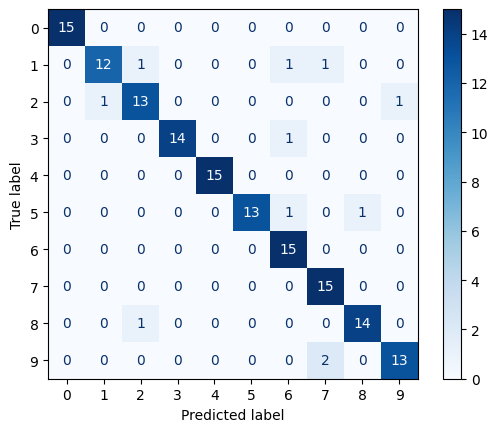

In [66]:
model.load_state_dict(torch.load('best_model.pth', weights_only=False))
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

cm = np.zeros((10, 10), dtype=int)

with torch.no_grad():  
    for inputs, labels in test_loader:
        outputs = model(inputs.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

cm = confusion_matrix(y_test, model(X_test_tensor.float()).argmax(dim=1).numpy())
cm_display = ConfusionMatrixDisplay(cm, display_labels=np.arange(10)).plot(cmap='Blues')
plt.show()